In [1]:
# =========================
# Global Visualization Style
# =========================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    style="white",        # 无网格白底
    font_scale=1.1        # 字号统一
)

# 全局 matplotlib 微调
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
    "figure.dpi": 100,
})

In [2]:
# =========================
# Color Palette (OrRd)
# =========================
ORRD = sns.color_palette("OrRd", 6)

COLOR_LIGHT = ORRD[1]   # baseline / weaker
COLOR_DARK  = ORRD[4]   # uplift / stronger

## STEP1: Define modelling question

Given post-level content and timing features, what factors are most associated with higher engagement (likes) on Red Note?

## STEP2: Data cleaning

Performed data cleaning including post-level deduplication to avoid sample bias caused by multi-tag scraping.

In [3]:
import pandas as pd
df = pd.read_csv("python_笔记标签.csv")
display(df.head())
df.info()
df.shape

,笔记标签,笔记标题,笔记点赞,发布时间
0,编程,现在的大学生找工作有多难？垃圾桶里翻简历,69,09:38
1,编程,最嚣张的程序员,391555,12:23
2,编程,教资面试娱乐版第十一次参加考试,415,10:36
3,编程,我们活在矩阵中吗？,39,11:02
4,编程,编程也可以很好玩😀,121692,01:07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3965 entries, 0 to 3964
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   笔记标签    3965 non-null   object
 1   笔记标题    3965 non-null   object
 2   笔记点赞    3965 non-null   int64 
 3   发布时间    3965 non-null   object
dtypes: int64(1), object(3)
memory usage: 124.0+ KB


(3965, 4)

In [4]:
missing_summary = df.isna().sum().to_frame("missing_count")
missing_summary["missing_ratio"] = missing_summary["missing_count"] / len(df)
missing_summary.sort_values("missing_ratio", ascending=False)

,missing_count,missing_ratio
笔记标签,0,0.0
笔记标题,0,0.0
笔记点赞,0,0.0
发布时间,0,0.0


In [5]:
df["发布时间"] = pd.to_datetime(df["发布时间"], format="%H:%M", errors="coerce")
df["post_hour"] = df["发布时间"].dt.hour
df["发布时间"] = df["发布时间"].dt.time
df["post_hour"]

0        9
1       12
2       10
3       11
4        1
        ..
3960     7
3961    14
3962    13
3963     4
3964    15
Name: post_hour, Length: 3965, dtype: int32

In [6]:
# 看看是否有完全重复的帖子（标题 + 发布时间）
dup_mask = df.duplicated(subset=["笔记标题", "发布时间"], keep=False)

df[dup_mask].sort_values(["笔记标题", "发布时间"])

,笔记标签,笔记标题,笔记点赞,发布时间,post_hour
1305,python,100天 从0开始学Python-Day1,2100,16:38:00,16
2295,python学习,100天 从0开始学Python-Day1,2100,16:38:00,16
1073,python,100天学Python：新手入门Python代码实例❗,5,05:19:00,5
2055,python学习,100天学Python：新手入门Python代码实例❗,5,05:19:00,5
696,编程,10大最危险的CMD指令❗,236,11:24:00,11
...,...,...,...,...,...
1956,python,🔥这几个老师恨不得把计算机嚼碎喂给你…,5353,15:53:00,15
1179,python,🧠 解锁编程利器：PyCharm安装详解！🚀,419,23:10:00,23
2900,python学习,🧠 解锁编程利器：PyCharm安装详解！🚀,419,23:10:00,23
1952,python,🫡py笔记|一篇文章搞清楚*args和**kwargs,402,05:03:00,5


In [7]:
dup_rate = df.duplicated(subset=["笔记标题", "发布时间"]).mean()
print(f"Duplicate rate: {dup_rate:.2%}")

Duplicate rate: 10.32%


## STEP3: EDA (round 1: understand data & target)

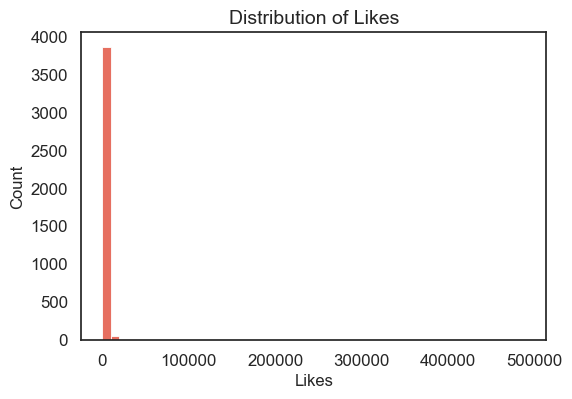

0.950      5655.200
0.990     23286.920
0.995     43366.880
0.999    123601.872
Name: 笔记点赞, dtype: float64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df["笔记点赞"], bins=50, color=COLOR_DARK)
plt.title("Distribution of Likes")
plt.xlabel("Likes")
plt.show()

df["笔记点赞"].quantile([0.95, 0.99, 0.995, 0.999])

Engagement exhibits a heavy-tailed distribution with a small number of viral posts.
Rather than removing extreme values, I applied a log transformation to stabilize variance while preserving real high-performing content in the next step.

### Why not winsorize?

I avoided winsorization because high-engagement posts are meaningful rather than erroneous.
Instead, I applied a log transformation to stabilize variance while preserving relative differences.

## STEP4: Feature engineering

In [9]:
import numpy as np
df["log_likes"] = np.log1p(df["笔记点赞"])

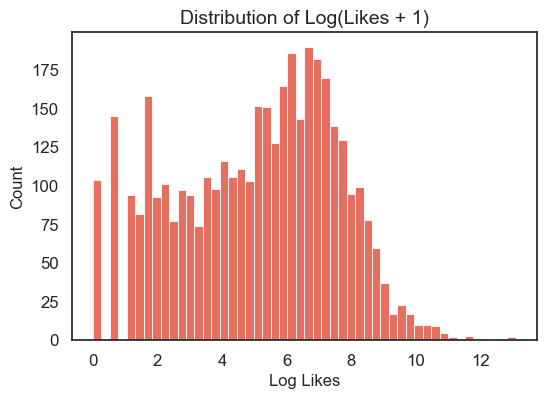

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df["log_likes"], bins=50, color=COLOR_DARK)
plt.title("Distribution of Log(Likes + 1)")
plt.xlabel("Log Likes")
plt.show()

In [11]:
df['笔记标签'].value_counts()

笔记标签
编程          1000
python学习     990
CS           990
python       985
Name: count, dtype: int64

In [12]:
top_tags = ["编程", "python学习", "CS", "python"]

In [13]:
for tag in top_tags:
    df[f"tag_{tag}"] = df["笔记标签"].apply(
        lambda x: 1 if isinstance(x, str) and tag in x else 0
    )

In [14]:
df["num_top_tags"] = df[[f"tag_{t}" for t in top_tags]].sum(axis=1)

In [15]:
!pip install emoji


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [16]:
import emoji

# 确保标题是字符串
df["笔记标题"] = df["笔记标题"].astype(str)

# 文本长度
df["text_length"] = df["笔记标题"].str.len()

# emoji 数量
df["emoji_count"] = df["笔记标题"].apply(
    lambda x: len(emoji.emoji_list(x))
)

# 是否包含 emoji
df["has_emoji"] = (df["emoji_count"] > 0).astype(int)

In [17]:
df.head()

,笔记标签,笔记标题,笔记点赞,发布时间,post_hour,log_likes,tag_编程,tag_python学习,tag_CS,tag_python,num_top_tags,text_length,emoji_count,has_emoji
0,编程,现在的大学生找工作有多难？垃圾桶里翻简历,69,09:38:00,9,4.248495,1,0,0,0,1,20,0,0
1,编程,最嚣张的程序员,391555,12:23:00,12,12.877884,1,0,0,0,1,7,0,0
2,编程,教资面试娱乐版第十一次参加考试,415,10:36:00,10,6.030685,1,0,0,0,1,15,0,0
3,编程,我们活在矩阵中吗？,39,11:02:00,11,3.688879,1,0,0,0,1,9,0,0
4,编程,编程也可以很好玩😀,121692,01:07:00,1,11.709257,1,0,0,0,1,9,1,1


In [18]:
df['num_top_tags'].value_counts()

num_top_tags
1    2975
2     990
Name: count, dtype: int64

The number of tags only have two values, so this tag itself was less important than which tags were used. I dropped it.

In [19]:
df = df.drop(columns='num_top_tags')

### Adjust schema violation

In [20]:
display(df['text_length'].value_counts().sort_values(ascending=False))
longest = df[df['text_length']==39]
display(longest['笔记标题'])

text_length
20    426
19    378
21    314
18    272
23    238
22    233
17    228
15    201
16    200
14    156
24    153
13    151
12    142
25    121
11     99
10     97
9      78
26     67
40     65
8      57
27     51
7      35
29     30
6      29
5      25
31     24
28     22
4      13
32     11
30     11
33      9
34      8
38      5
37      4
3       4
36      4
2       3
39      1
Name: count, dtype: int64

157    手机出现这3个信号你就得小心了 黑客   编程   知识   科普   程序员
Name: 笔记标题, dtype: object

Based on platform constraints, titles longer than 20 characters were treated as missing titles caused by scraping errors and corrected accordingly.

In [21]:
MAX_TITLE_LEN = 20

df["has_valid_title"] = (df["text_length"] <= MAX_TITLE_LEN).astype(int)

In [22]:
df["text_length"] = df["text_length"].where(
    df["text_length"] <= MAX_TITLE_LEN,
    0
)
display(df['text_length'].value_counts())
display(df['has_valid_title'].value_counts())

text_length
0     1371
20     426
19     378
18     272
17     228
15     201
16     200
14     156
13     151
12     142
11      99
10      97
9       78
8       57
7       35
6       29
5       25
4       13
3        4
2        3
Name: count, dtype: int64

has_valid_title
1    2594
0    1371
Name: count, dtype: int64

In [23]:
display(df.head())

,笔记标签,笔记标题,笔记点赞,发布时间,post_hour,log_likes,tag_编程,tag_python学习,tag_CS,tag_python,text_length,emoji_count,has_emoji,has_valid_title
0,编程,现在的大学生找工作有多难？垃圾桶里翻简历,69,09:38:00,9,4.248495,1,0,0,0,20,0,0,1
1,编程,最嚣张的程序员,391555,12:23:00,12,12.877884,1,0,0,0,7,0,0,1
2,编程,教资面试娱乐版第十一次参加考试,415,10:36:00,10,6.030685,1,0,0,0,15,0,0,1
3,编程,我们活在矩阵中吗？,39,11:02:00,11,3.688879,1,0,0,0,9,0,0,1
4,编程,编程也可以很好玩😀,121692,01:07:00,1,11.709257,1,0,0,0,9,1,1,1


### Drop duplication

In [24]:
before = len(df)

df_clean = df.drop_duplicates(
    subset=["笔记标题", "发布时间"],
    keep="first"
)

after = len(df_clean)

print(f"Before dedup: {before}")
print(f"After dedup: {after}")
print(f"Removed: {before - after} ({(before - after)/before:.2%})")

Before dedup: 3965
After dedup: 3556
Removed: 409 (10.32%)


### Cleaned dataset info

In [25]:
display(df_clean.head())
df_clean.info()
df_clean.shape

,笔记标签,笔记标题,笔记点赞,发布时间,post_hour,log_likes,tag_编程,tag_python学习,tag_CS,tag_python,text_length,emoji_count,has_emoji,has_valid_title
0,编程,现在的大学生找工作有多难？垃圾桶里翻简历,69,09:38:00,9,4.248495,1,0,0,0,20,0,0,1
1,编程,最嚣张的程序员,391555,12:23:00,12,12.877884,1,0,0,0,7,0,0,1
2,编程,教资面试娱乐版第十一次参加考试,415,10:36:00,10,6.030685,1,0,0,0,15,0,0,1
3,编程,我们活在矩阵中吗？,39,11:02:00,11,3.688879,1,0,0,0,9,0,0,1
4,编程,编程也可以很好玩😀,121692,01:07:00,1,11.709257,1,0,0,0,9,1,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 3556 entries, 0 to 3964
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   笔记标签             3556 non-null   object 
 1   笔记标题             3556 non-null   object 
 2   笔记点赞             3556 non-null   int64  
 3   发布时间             3556 non-null   object 
 4   post_hour        3556 non-null   int32  
 5   log_likes        3556 non-null   float64
 6   tag_编程           3556 non-null   int64  
 7   tag_python学习     3556 non-null   int64  
 8   tag_CS           3556 non-null   int64  
 9   tag_python       3556 non-null   int64  
 10  text_length      3556 non-null   int64  
 11  emoji_count      3556 non-null   int64  
 12  has_emoji        3556 non-null   int64  
 13  has_valid_title  3556 non-null   int64  
dtypes: float64(1), int32(1), int64(9), object(3)
memory usage: 402.8+ KB


(3556, 14)

In [26]:
df_clean[["tag_编程", "tag_python", "tag_CS", "tag_python学习"]].mean()

tag_编程          0.281215
tag_python      0.441507
tag_CS          0.277278
tag_python学习    0.194601
dtype: float64

## STEP5: EDA (round 2: sanity check before modelling)

### Aims of this stage

1：确认每个 feature 与 target 是否“有区分度” \
2：确认关系方向“符合业务直觉” \
3：判断“是否需要更复杂模型”

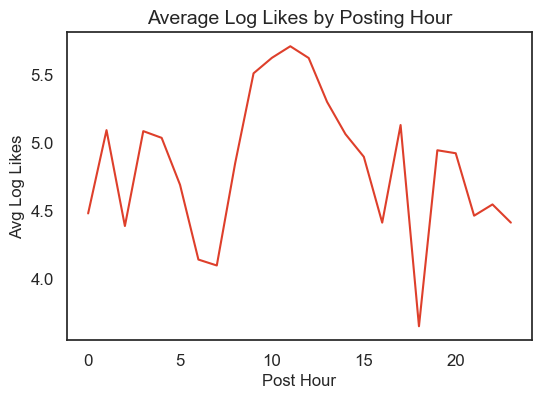

In [27]:
hourly_mean = (
    df_clean
    .groupby("post_hour")["log_likes"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.lineplot(x="post_hour", y="log_likes", data=hourly_mean, color=COLOR_DARK)
plt.title("Average Log Likes by Posting Hour")
plt.xlabel("Post Hour")
plt.ylabel("Avg Log Likes")
plt.show()

Posting hour shows a clear non-linear relationship with engagement, with distinct peak and trough periods rather than a monotonic trend.

/Users/xiada/.venvs/jup/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xiada/.venvs/jup/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


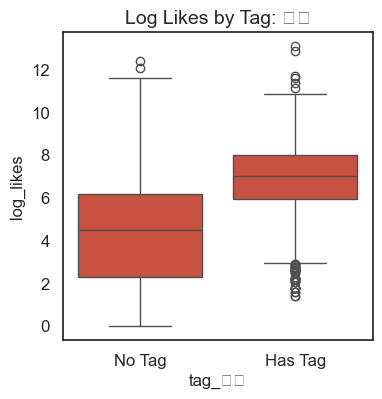

In [28]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="tag_编程",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Tag", "Has Tag"])
plt.title("Log Likes by Tag: 编程")
plt.show()

/Users/xiada/.venvs/jup/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xiada/.venvs/jup/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


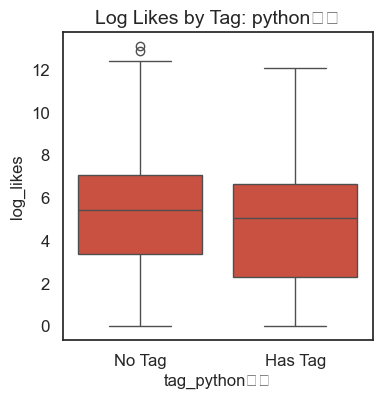

In [29]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="tag_python学习",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Tag", "Has Tag"])
plt.title("Log Likes by Tag: python学习")
plt.show()

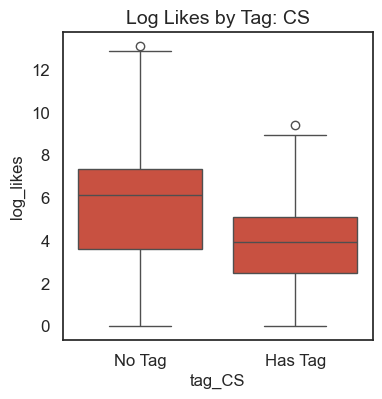

In [30]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="tag_CS",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Tag", "Has Tag"])
plt.title("Log Likes by Tag: CS")
plt.show()

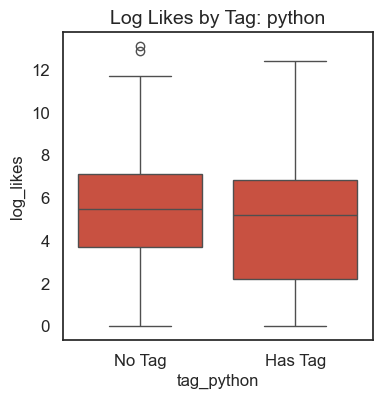

In [31]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="tag_python",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Tag", "Has Tag"])
plt.title("Log Likes by Tag: python")
plt.show()

Individual topic tags do not show strong positive effects in isolation.
This suggests engagement is driven by interactions between content topic, posting time, and presentation style.

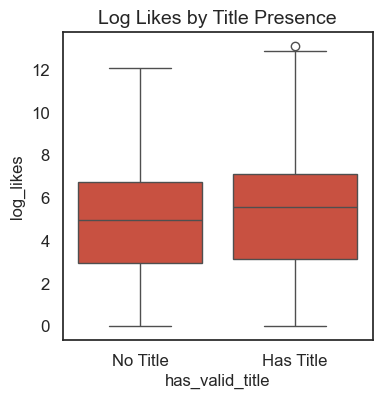

In [32]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="has_valid_title",
    y="log_likes",
    data=df_clean, 
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Title", "Has Title"])
plt.title("Log Likes by Title Presence")
plt.show()

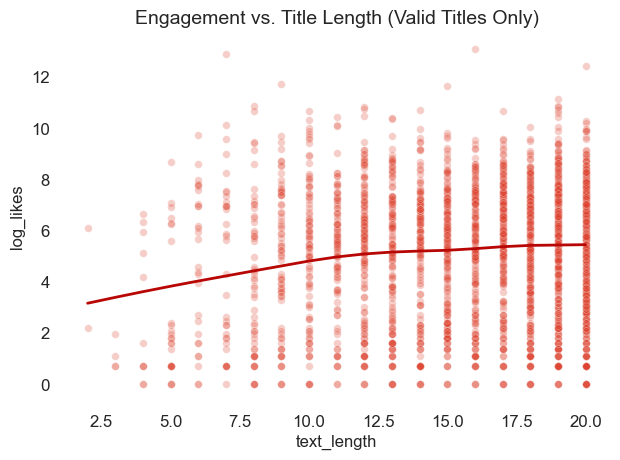

In [33]:
df_title = df_clean[df_clean["text_length"] > 0]

ax = sns.scatterplot(
    data=df_title,
    x="text_length",
    y="log_likes",
    color=COLOR_DARK,   # 使用统一的 OrRd 深色
    alpha=0.25,         # 低透明度，看密度
    s=30                # 点大小，适中
)

ax.set_xlabel("Title Length")
ax.set_ylabel("Engagement (log scale)")
ax.set_title("Engagement vs. Title Length (Valid Titles Only)")

# 视觉清理
sns.despine(left=True, bottom=True)
ax.xaxis.grid(False)

sns.regplot(
    data=df_title,
    x="text_length",
    y="log_likes",
    scatter=False,
    lowess=True,
    color=ORRD[5],
    line_kws={"linewidth": 2}
)

plt.tight_layout()
plt.show()

Title length exhibits a weak monotonic relationship with engagement, with diminishing marginal returns, suggesting it acts as a secondary feature rather than a primary driver.

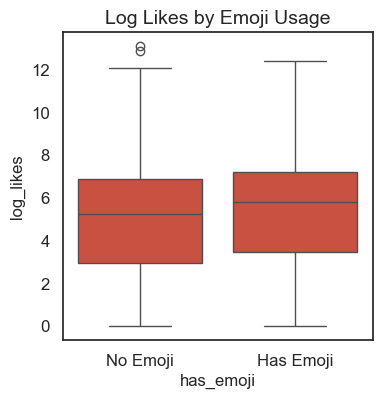

In [34]:
plt.figure(figsize=(4,4))
sns.boxplot(
    x="has_emoji",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.xticks([0,1], ["No Emoji", "Has Emoji"])
plt.title("Log Likes by Emoji Usage")
plt.show()

Emoji usage improves engagement on average, but its effect is secondary compared to timing and topic.

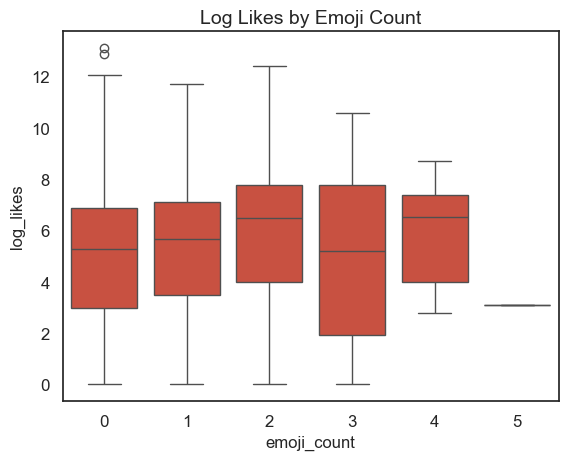

In [35]:
sns.boxplot(
    x="emoji_count",
    y="log_likes",
    data=df_clean,
    color=COLOR_DARK
)
plt.title("Log Likes by Emoji Count")
plt.show()

Engagement increases when a small number of emojis are used, but the effect plateaus and becomes noisy as emoji count increases, indicating diminishing returns.

### Summary

Engagement is influenced by multiple weak signals rather than a single dominant factor.

Posting time shows clear non-linear patterns, while topic tags and text features exhibit weaker marginal effects.

Emoji usage provides a small but consistent uplift, with diminishing returns beyond a few emojis.

These observations support the use of a non-linear model to capture interactions across features.

## STEP 6: Modelling

In [36]:
from sklearn.model_selection import train_test_split

features = [
    "post_hour",
    "has_valid_title",
    "text_length",
    "has_emoji",
    "emoji_count",
    "tag_编程",
    "tag_python学习",
    "tag_CS",
    "tag_python",
]

X = df_clean[features]
y = df_clean["log_likes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R2: 0.242
RMSE: 2.183


The model is not intended for high-precision prediction.\
Its primary goal is to identify relative importance of content and timing features, which is why I prioritized model stability and interpretability over raw performance.

In [39]:
features_no_main_tag = [
    f for f in features if f != "tag_编程"
]
X2 = df_clean[features_no_main_tag]
y2 = df_clean["log_likes"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2,
    test_size=0.2,
    random_state=42
)

In [40]:
rf2 = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf2.fit(X2_train, y2_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
y2_pred = rf2.predict(X2_test)

r2 = r2_score(y2_test, y2_pred)
rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))

print(f"R2_update: {r2:.3f}")
print(f"RMSE_update: {rmse:.3f}")

R2_update: 0.241
RMSE_update: 2.183


## STEP 7: Permutation importance

In [42]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

importances

,feature,importance_mean,importance_std
5,tag_编程,0.479044,0.035119
0,post_hour,0.027605,0.011831
8,tag_python,0.017926,0.009452
2,text_length,0.012939,0.008457
1,has_valid_title,0.003170,0.001473
4,emoji_count,0.000747,0.003474
3,has_emoji,-0.000275,0.002785
7,tag_CS,-0.000495,0.001478
6,tag_python学习,-0.000847,0.002126


Topic category features appear highly important under permutation analysis due to strong correlations with other features.

However, ablation experiments show that removing the main category tag does not significantly degrade model performance, indicating substantial information redundancy.

This suggests engagement is driven by a combination of finer-grained topic signals, timing, and presentation features rather than a single dominant tag.

## STEP 8: Finding insights (conditional analysis)

### 高峰时段 × emoji

In [43]:
from matplotlib.patches import Patch
plot_df = df_clean.groupby(
    ["is_peak_hour", "has_emoji"]
)["log_likes"].mean().reset_index()

# ===== 调色盘（精选两色）=====
palette = sns.color_palette("OrRd", 6)
COLOR_NO  = palette[1]   # 浅
COLOR_YES = palette[4]   # 深

plt.figure(figsize=(6.5, 4))

ax = sns.barplot(
    data=plot_df,
    x="is_peak_hour",
    y="log_likes",
    hue="has_emoji",
    hue_order=[0, 1],
    palette=[COLOR_NO, COLOR_YES],
    width=0.55
)

# x 轴
ax.set_xticks([0, 1])
ax.set_xticklabels(["Off-Peak", "Peak"])
ax.set_xlabel("")

# y 轴
ax.set_ylabel("Average Engagement (log scale)")
ax.set_ylim(4.5, 6.0)

# 标题（结论型）
ax.set_title(
    "Emoji Usage Provides Larger Gains During Off-Peak Hours",
    pad=12
)

# legend（手动绑定，永不翻车）
legend_elements = [
    Patch(facecolor=COLOR_NO,  label="No Emoji"),
    Patch(facecolor=COLOR_YES, label="Has Emoji"),
]

ax.legend(
    handles=legend_elements,
    title="Emoji Usage",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

# 视觉清理
sns.despine(left=True, bottom=True)
ax.yaxis.grid(True, color="#E6E6E6", linewidth=1)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

KeyError: 'is_peak_hour'

### 高峰时段 × title presence

In [ ]:
plot_df = df_clean.groupby(
    ["is_peak_hour", "has_valid_title"]
)["log_likes"].mean().reset_index()

# ========= OrRd 调色盘（与你第一张一致） =========
palette = sns.color_palette("OrRd", 6)
COLOR_NO  = palette[1]   # 浅橙
COLOR_YES = palette[4]   # 深橙红

plt.figure(figsize=(6.5, 4))

ax = sns.barplot(
    data=plot_df,         
    x="is_peak_hour",
    y="log_likes",
    hue="has_valid_title",
    hue_order=[0, 1],
    palette=[COLOR_NO, COLOR_YES],
    width=0.55
)

# ========= x 轴 =========
ax.set_xticks([0, 1])
ax.set_xticklabels(["Off-Peak", "Peak"])
ax.set_xlabel("")

# ========= y 轴 =========
ax.set_ylabel("Average Engagement (log scale)")
ax.set_ylim(4.5, 6.0)

# ========= 标题（结论型，和第一张一致风格） =========
ax.set_title(
    "Titles Matter More When Baseline Visibility Is High",
    pad=12
)

# ========= Legend（手动绑定，永不翻车） =========
legend_elements = [
    Patch(facecolor=COLOR_NO,  label="No Title"),
    Patch(facecolor=COLOR_YES, label="Has Title"),
]

ax.legend(
    handles=legend_elements,
    title="Title Presence",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

# ========= 视觉清理 =========
sns.despine(left=True, bottom=True)
ax.yaxis.grid(True, color="#E6E6E6", linewidth=1)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

### emoji count × title length

In [ ]:
from matplotlib.lines import Line2D
# ===== 数据准备 =====
plot_df = (
    df_clean.assign(
        short_title = (df_clean["text_length"] <= 8).astype(int)
    )
    .groupby(["emoji_count", "short_title"])["log_likes"]
    .mean()
    .reset_index()
)

# ===== 关键：限制主分析区间（避免伪趋势）=====
plot_df_main = plot_df[plot_df["emoji_count"] <= 4]

# ===== OrRd 调色盘（与你前两张一致）=====
palette = sns.color_palette("OrRd", 6)
COLOR_LONG  = palette[1]   # Long title（浅）
COLOR_SHORT = palette[4]   # Short title（深）

sns.set_theme(style="white", font_scale=1.1)

# ===== 只画一张图 =====
plt.figure(figsize=(6.5, 4))

ax = sns.lineplot(
    data=plot_df_main,
    x="emoji_count",
    y="log_likes",
    hue="short_title",
    hue_order=[0, 1],
    palette=[COLOR_LONG, COLOR_SHORT],
    marker="o",
    linewidth=2.4
)

# ===== 轴设置 =====
ax.set_xlabel("Emoji Count")
ax.set_ylabel("Average Engagement (log scale)")
ax.set_ylim(4.5, 6.5)

# ===== 标题（结论型）=====
ax.set_title(
    "Moderate Emoji Usage Enhances Short Titles, With Diminishing Returns",
    pad=12
)

# ===== Legend（统一为 Line2D）=====
legend_elements = [
    Line2D([0], [0], color=COLOR_LONG,  marker='o', linewidth=2.4, label="Long Title"),
    Line2D([0], [0], color=COLOR_SHORT, marker='o', linewidth=2.4, label="Short Title"),
]

ax.legend(
    handles=legend_elements,
    title="Title Length",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

# ===== 视觉清理 =====
sns.despine(left=True, bottom=True)
ax.yaxis.grid(True, color="#E6E6E6", linewidth=1)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

### Summary

Timing is the primary driver of engagement

Emojis act as an attention booster, especially when baseline visibility is low

Presentation features cannot replace good timing, but can partially compensate for it

No single tactic guarantees success; strategies should adapt to posting context